In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import gpytorch
import lbg_forecast.priors_gp_massfunc as gpmf

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
744.399904025542
702.6312990544928
660.1455196945052
617.1278691649643
573.7786974125248
530.3245852133886
487.0070726792582
444.08946814474547
401.8435821972061
360.5489553001987
320.4907624586646
281.9442864712903
245.18234594042505
210.46628189197725
178.0337337547795
148.09576530869967
120.83147476725755
96.37889280487595
74.83200080931728
56.22917506910922
40.55976111933003
27.75321601763462
17.68192222731026
10.166095284450721
4.974471729443756
1.8348853769677604
0.4415219622323287
0.2919619261373103
0.28228101733306266
0.2737147785410516
0.26608067702998994
0.2592347146512873
0.2530621659280547
0.24747039349846275
0.2423836580225327
0.23773923625595603
0.2334845990027513
0.22957533353057516
0.22597351785757783
0.22264647381733127
0.21956581183811608
0.21670685407369625
0.21404779001406737
0.21156949335425165
0.20925495301300792
0.207089051

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


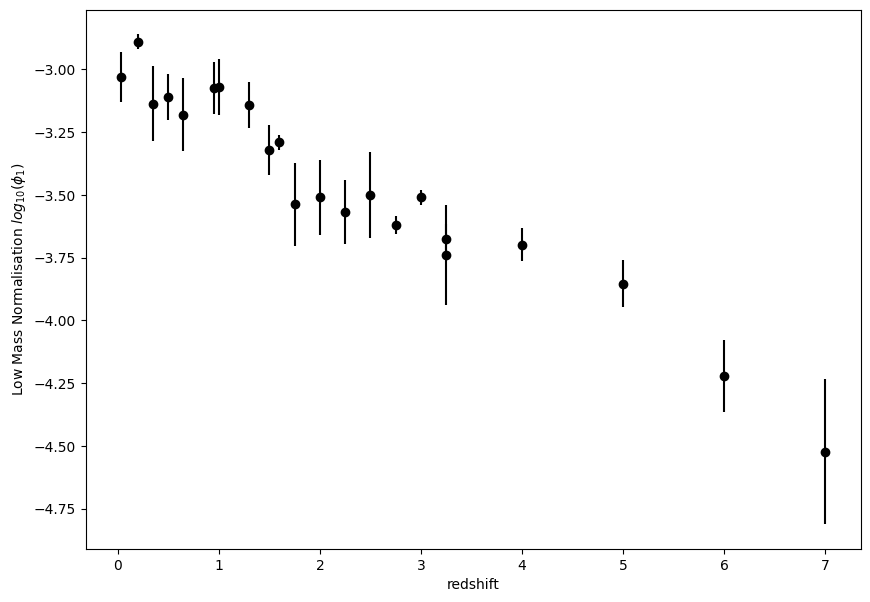

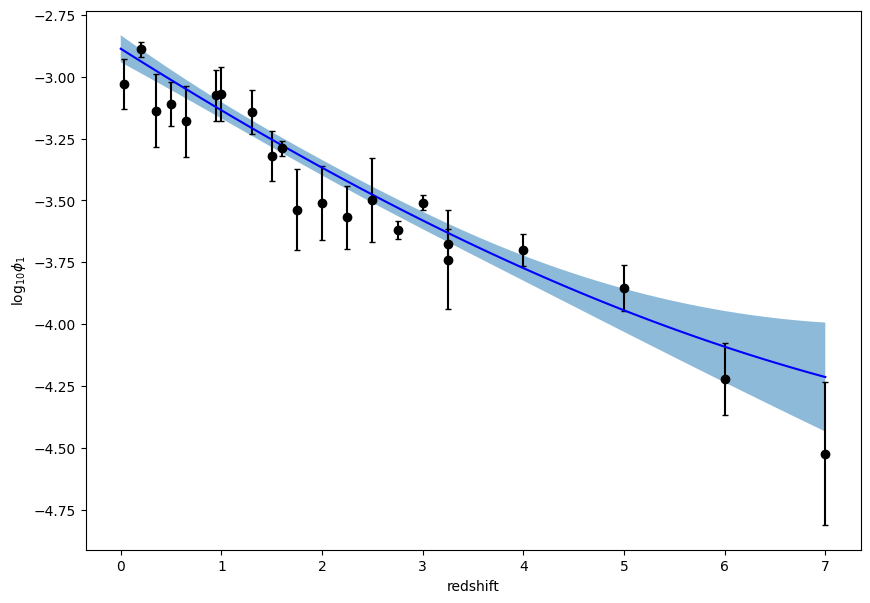

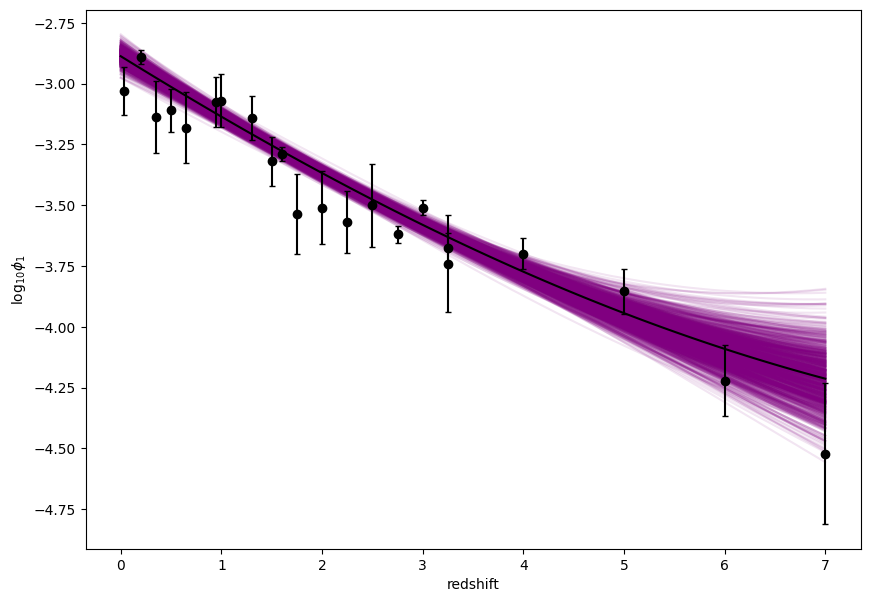

In [2]:
sorted_train_redshift, sorted_train_logphi1, sorted_train_logphi1_errs = gpmf.get_phi1_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_logphi1, sorted_train_logphi1_errs, torch.linspace(0, 7, 100), lengthscale=[2.5, 99.0], lr=0.1, training_iter=20000, ylabel="$\mathrm{log}_{10}\phi_{1}$", name="phi1")


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
1022.6480130001311
965.5011857267342
907.3275599889121
848.3818871644106
788.9512714557475
729.3528380941196
669.9212165674396
611.0155853769239
553.0105658081943
496.2931344450328
441.2574034844104
388.2957493775324
337.7818425563741
290.0757594708246
245.51091365806656
204.3761519478863
166.92182263607253
133.3353159054829
103.74406775708327
78.20559830275845
56.69914217839752
39.12950830084625
25.32106983463791
15.025400775545878
7.9234553619394354
3.6398893807705086
1.753959561739489
1.567585500889684
1.5658242685257
1.5640073821336264
1.5621254568490994
1.5601808627903724
1.5581820611723074
1.556140075570433
1.5540665775764042
1.551972710560332
1.5498686614977515
1.5477633150108823
1.5456642844819135
1.5435779643305927
1.5415095780936798
1.5394634140267325
1.5374428715455353
1.5354506129272147
1.533488650635447
1.5315585023290736
1.529661251

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


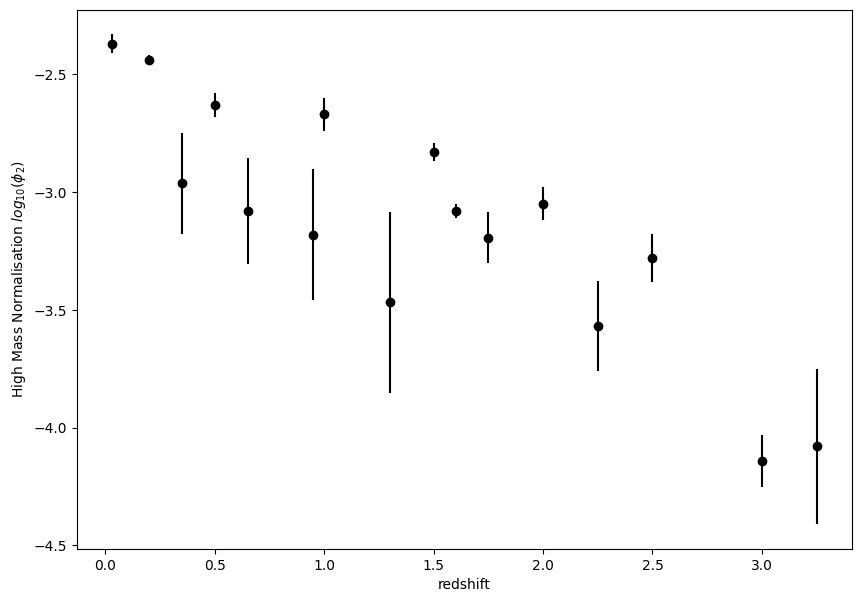

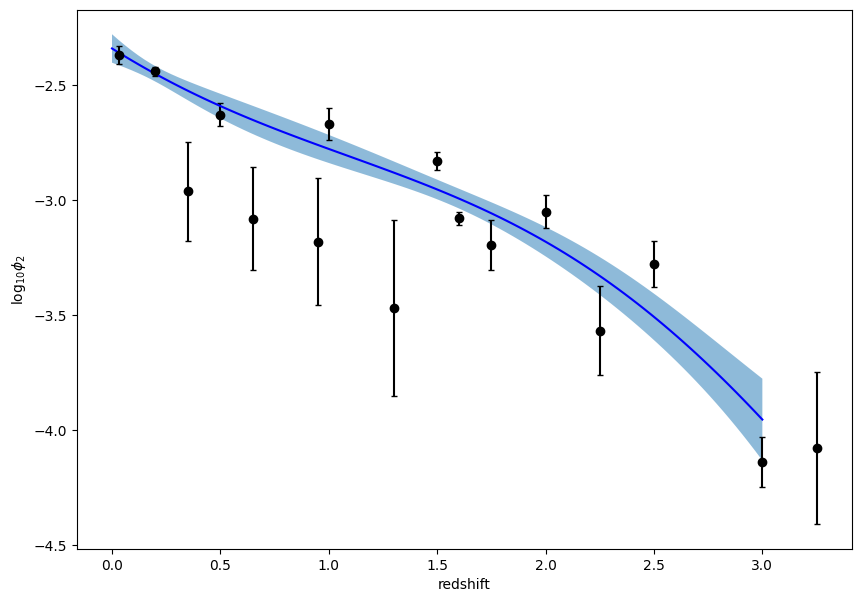

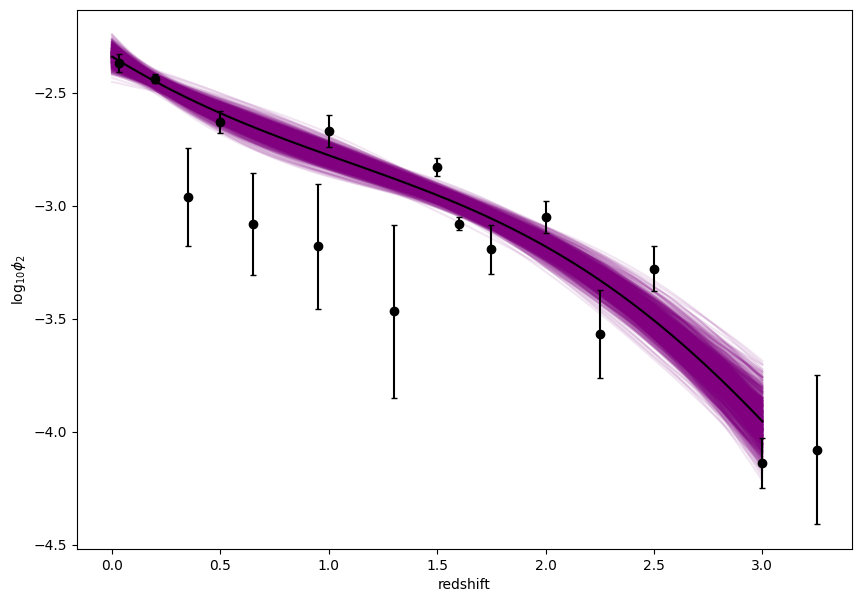

In [2]:
sorted_train_redshift, sorted_train_logphi2, sorted_train_logphi2_errs = gpmf.get_phi2_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_logphi2, sorted_train_logphi2_errs, torch.linspace(0, 3, 100), lengthscale=[2.5, 99.0], lr=0.1, training_iter=10000, ylabel="$\mathrm{log}_{10}\phi_{2}$", name="phi2")


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
116486.32639870439
115868.6641008477
115222.10282687547
114546.68960696748
113842.54187223333
113109.87116491268
112349.13902517008
111560.89989978165
110745.72240105808
109904.51768907682
109038.14983370053
108147.66335092716
107234.15860544324
106298.95571517135
105343.25821885931
104368.5667746911
103376.23361380641
102367.71242799674
101344.55833701229
100308.21696029718
99260.19631676144
98201.96528867215
97134.93801768319
96060.62235732822
94980.27613216064
93895.28214430236
92806.86692837854
91716.25700653781
90624.55389341191
89532.79660068873
88442.09445332477
87353.2755295389
86267.25384959625
85184.82625109816
84106.74270111902
83033.65160804923
81966.2560708779
80905.0326286388
79850.53594747095
78803.21913286527
77763.49622958225
76731.75784673511
75708.35553271291
74693.53146286128
73687.55906451245
72690.6961417703
71703.1145631052

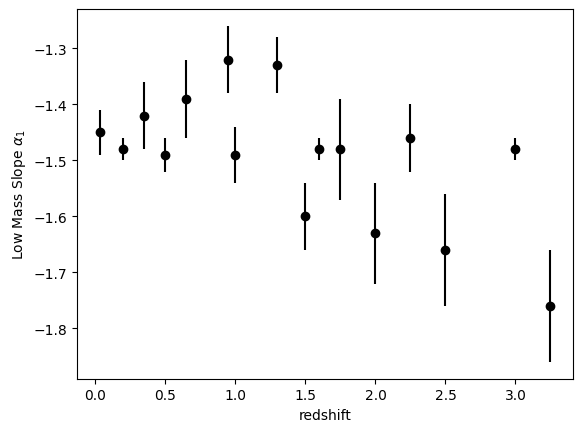

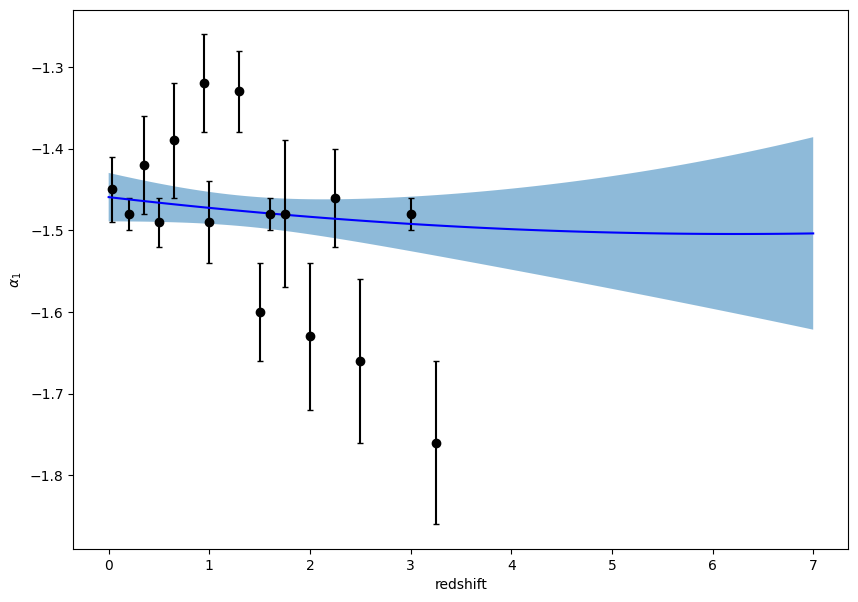

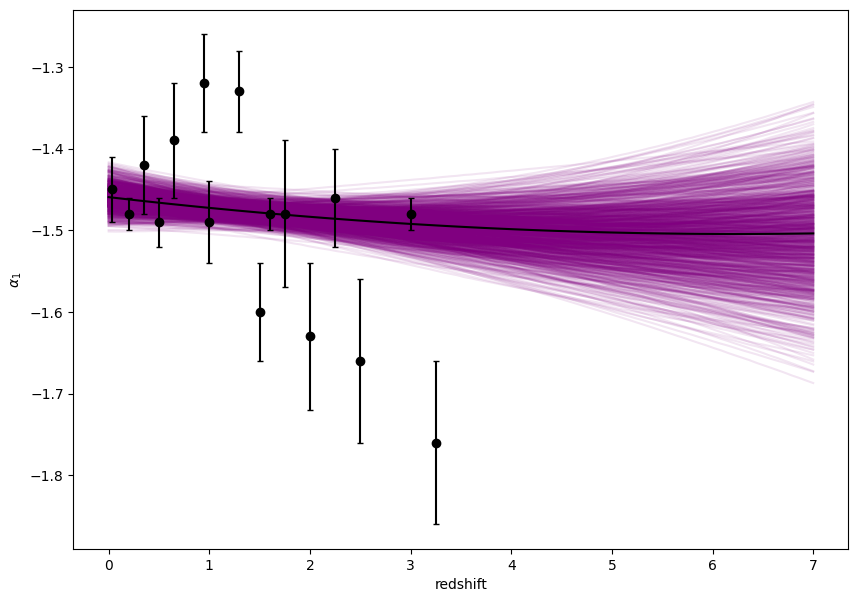

In [3]:
sorted_train_redshift, sorted_train_alpha1, sorted_train_alpha1_errs = gpmf.get_alpha1_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_alpha1, sorted_train_alpha1_errs, torch.linspace(0.0, 7.0, 100), lengthscale=[20.0, 99.0], lr=0.1, training_iter=20000, ylabel="$\\alpha_{1}$", name="alpha1")

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
1020.9676644905468
963.88926068714
905.773539918399
846.8782599375613
787.4914703063614
727.9313661924512
668.534402568346
609.6615097374525
551.6881518407384
495.00418999831334
439.99983559000094
387.06152332487153
336.5734551442376
288.8897466486095
244.34353685225366
203.22549842041596
165.78024399161345
132.20109963002494
102.61387754731327
77.07538258362563
55.56690399888595
37.99295011247197
24.18022082770776
13.878266287516265
6.771178987642889
2.4832150991182607
0.5938057107044917
0.404700313804206
0.40066976804645216
0.39715164452535623
0.3941086045955352
0.3915051145633983
0.38930649462303835
0.387478262636757
0.385985643297736
0.38479328175819716
0.3838652298790206
0.38316512392100543
0.3826566030135192
0.382303929414173
0.3820726810968813
0.3819305179238792
0.3818479731041122
0.3817990997594004
0.3817620439355818
0.38171934386903783
0

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


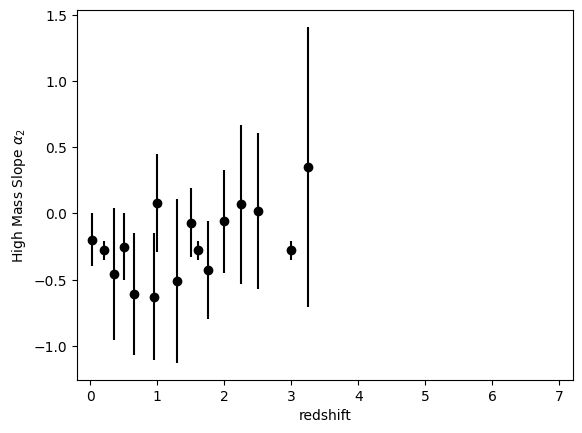

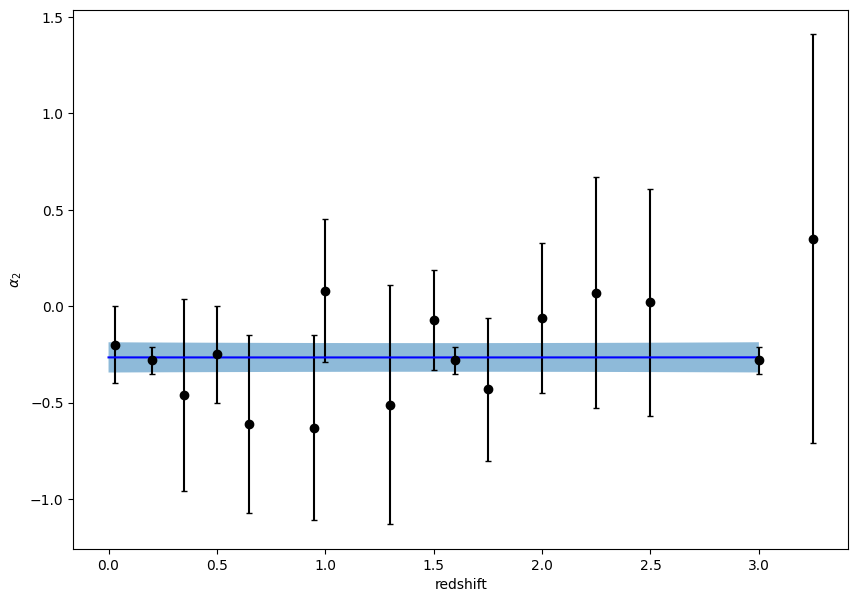

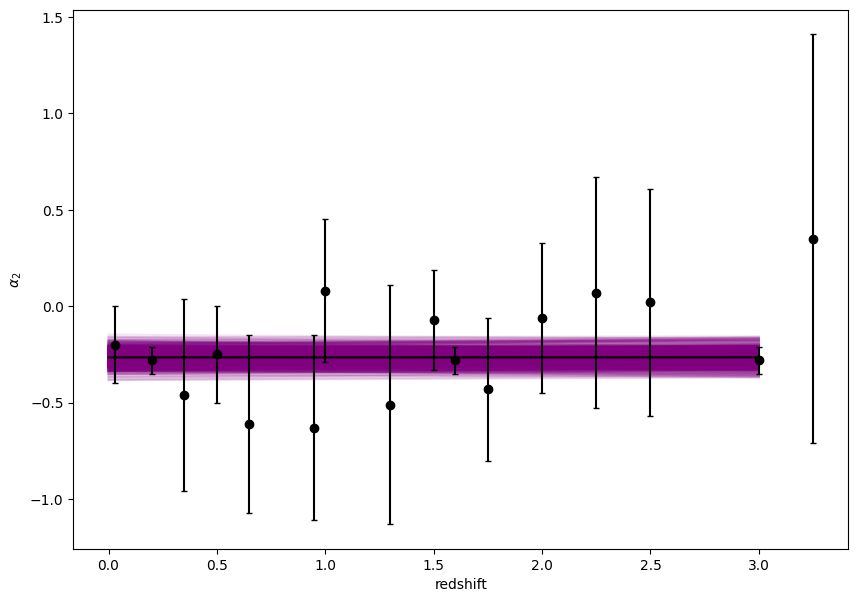

In [2]:
sorted_train_redshift, sorted_train_alpha2, sorted_train_alpha2_errs = gpmf.get_alpha2_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_alpha2, sorted_train_alpha2_errs, torch.linspace(0, 3, 100), lengthscale=[2.5, 99.0], lr=0.1, training_iter=20000, ylabel="$\\alpha_{2}$", name="alpha2")

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
761.124078522834
717.5239220482866
673.4936851516311
629.1859556179061
584.76870308489
540.431538038534
496.3852659056848
452.8566477430044
410.08524157524494
368.32657992800137
327.8516232774639
288.93594380294695
251.84909203464332
216.84527015558186
184.1571557895023
153.99143425565455
126.52140039898607
101.88137789585035
80.1598770393535
61.394990803988726
45.57018933187944
32.61320475794132
22.395801581673997
14.736374868637357
9.404851202426242
6.129924391560357
4.608480772035887
4.373377178650825
4.31520342845178
4.262087998450276
4.213352730939801
4.168452837551399
4.126941511112142
4.088444452287097
4.052644058132916
4.019265894539779
3.988071791617885
3.958852372421735
3.931423119370979
3.905619529573345
3.8812955375623024
3.85832027284043
3.8365760283944113
3.815957701874078
3.7963697264826353
3.7777266224240695
3.759950790519621
3.74

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


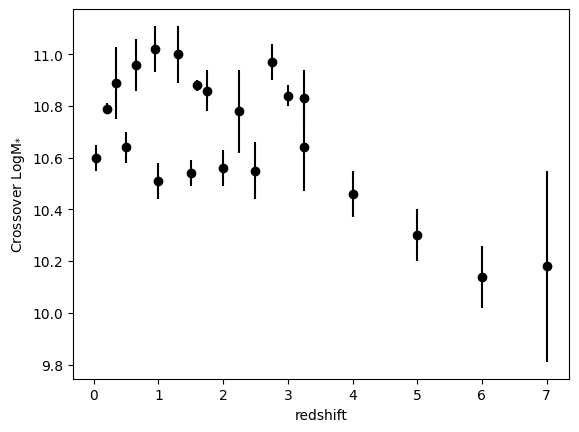

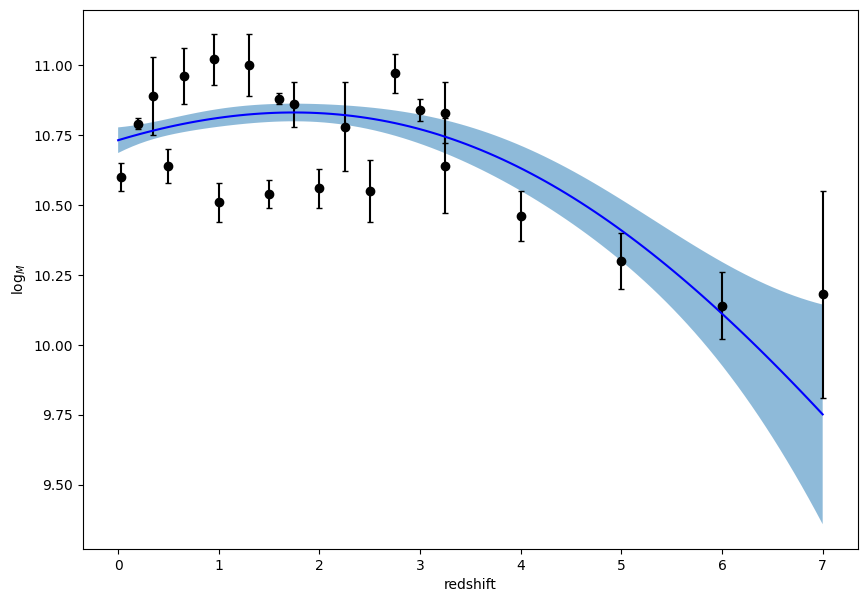

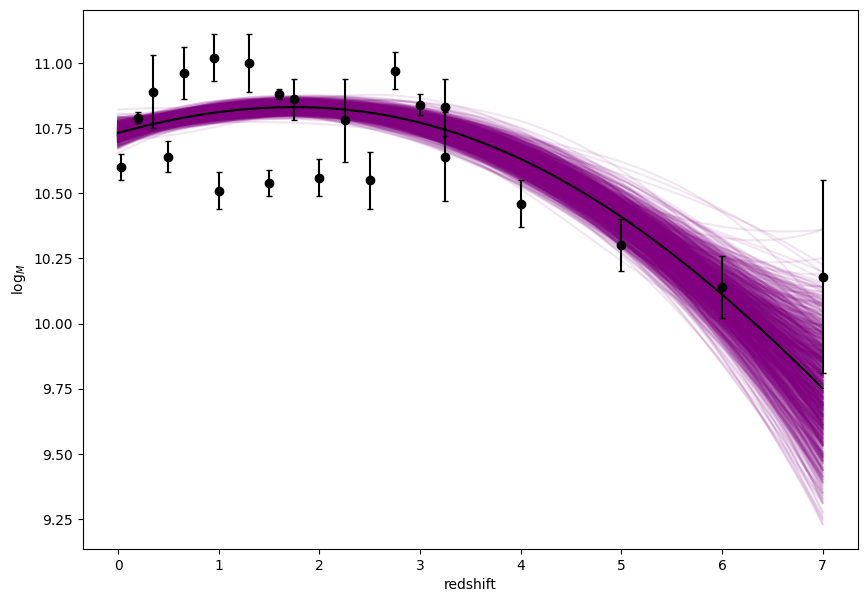

In [2]:
sorted_train_redshift, sorted_train_logm, sorted_train_logm_errs = gpmf.get_logm_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_logm, sorted_train_logm_errs, torch.linspace(0, 7, 100), lengthscale=[2.5, 7.0], lr=0.1, training_iter=10000, ylabel="$\mathrm{log}_{M}$", name="logm")